### ***Main info*** ###

***Project description:*** https://www.kaggle.com/competitions/bike-sharing-demand/overview/description

***Project goal:*** combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

***Notebook goal:*** make final LSTM model and integrate it with neptune 

<p>

### ***0. Project preparation*** ###

---

In [173]:
# basic imports
import os
import random
from math import sqrt
from itertools import product
import neptune

# from neptune.new.integrations.tensorflow_keras import NeptuneCallback
import json

# ml imports
import numpy as np
import pandas as pd
import tensorflow as tf

# sklearn imports
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# plotting imports and options
import matplotlib.pyplot as plt
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('ggplot')
%matplotlib inline

# keras imports
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense, Bidirectional
from tensorflow.keras import backend as K

In [174]:
# set same seed to everything
SEED_VALUE = 0
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
tf.compat.v1.set_random_seed(SEED_VALUE)

In [175]:
# run neptune server
def init_neptune(credentials_file = 'neptune_credentials.json'):
    '''
    Initialize neptune project
    '''
    with open(credentials_file) as f:
        neptune_credentials = json.load(f)

    run = neptune.init(
        api_token = neptune_credentials['API_TOKEN'],
        project_qualified_name = neptune_credentials['PROJECT']
    )
    return run

### ***1. Load data*** ###

---

In [176]:
df_train = pd.read_csv('inputs/train.csv', parse_dates = ['datetime'], index_col = 'datetime')
df_test = pd.read_csv('inputs/test.csv', parse_dates = ['datetime'], index_col = 'datetime')

In [177]:
df_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [178]:
df_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014


### ***2. Custom functions*** ###

---

2.1. Dataset functions

In [179]:
def between_dates(dataset: pd.DataFrame, start_date: str, start_time: str, end_date: str, end_time: str) -> pd.DataFrame:
    '''
    Show dataframe between two dates and timestamps
    
    Arguments:
        dataset: pandas DataFrame 
        start_date: date which the dataset must be trimmed from
        start_time: hour of day from start_date
        end_date: date which the dataset must be trimmed to
        end_time: hour of day from end_date

    Returns:
        A DataFrame between (start_date, start_time) and (end_date, end_time)
    '''

    start_dt = f'{start_date} {start_time}:00:00'
    end_dt = f'{end_date} {end_time}:00:00'
    mask = (dataset.index >= start_dt) & (dataset.index <= end_dt)
    return dataset[mask]

In [180]:
def select_test(year: int, month: int) -> pd.DataFrame:
  '''
  Return a dataframe of test dataset given a year and a month

  Arguments:
        year: year of dataset
        month: month of a given year

  Returns:
        A part of test dataset when datetime column corresponds to a given year and month
  '''
  next_month = month + 1
  if next_month == 13:
    next_month = 1
  month = str(month).zfill(2)
  next_month = str(next_month).zfill(2)

  if  month != '12':
    result = between_dates(df_test, f'{year}-{month}-01', '00', f'{year}-{next_month}-01', '00')
  else:
    result = between_dates(df_test, f'{year}-{month}-01', '00', f'{year+1}-{next_month}-01', '00')
  
  return result

In [181]:
def select_train(year: int, month: int) -> pd.DataFrame:
    '''
    Return a dataframe of train dataset given a year and a month

    Arguments:
            year: year of dataset
            month: month of a given year

    Returns:
            A part of train dataset when datetime column corresponds to a given year and month
    '''

    month = str(month).zfill(2)
    result = between_dates(df_train, f'{year}-{month}-01', '00', f'{year}-{month}-20', '00')
        
    return result 

2.2. Error metrics functions

In [182]:
# root mean squared error
def rmse(y_true, y_pred):
    '''
    Calculate Root Mean Squared Error for keras Sequential model

    Arguments:
            y_true: actual value of target variable
            y_pred: predicted value of target variable

    Returns:
            Root Mean Squared Error for given actual and predicted target variable
    '''
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# root mean squared logaritmic error
def rmsle(y_true, y_pred):
    '''
    Calculate Root Mean Squared Logharitmic Error for keras Sequential model

    Arguments:
            y_true: actual value of target variable
            y_pred: predicted value of target variable

    Returns:
            Root Mean Squared Logharitmic Error for given actual and predicted target variable
    '''
    return K.abs(K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true)))))

# coefficient of determination

def r2(y_true, y_pred):
    '''
    Calculate coefficient of determination for keras Sequential model

    Arguments:
            y_true: actual value of target variable
            y_pred: predicted value of target variable

    Returns:
            Coefficient of determination for given actual and predicted target variable
    '''
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### ***3. Visualise training datasets in every month*** ###

---

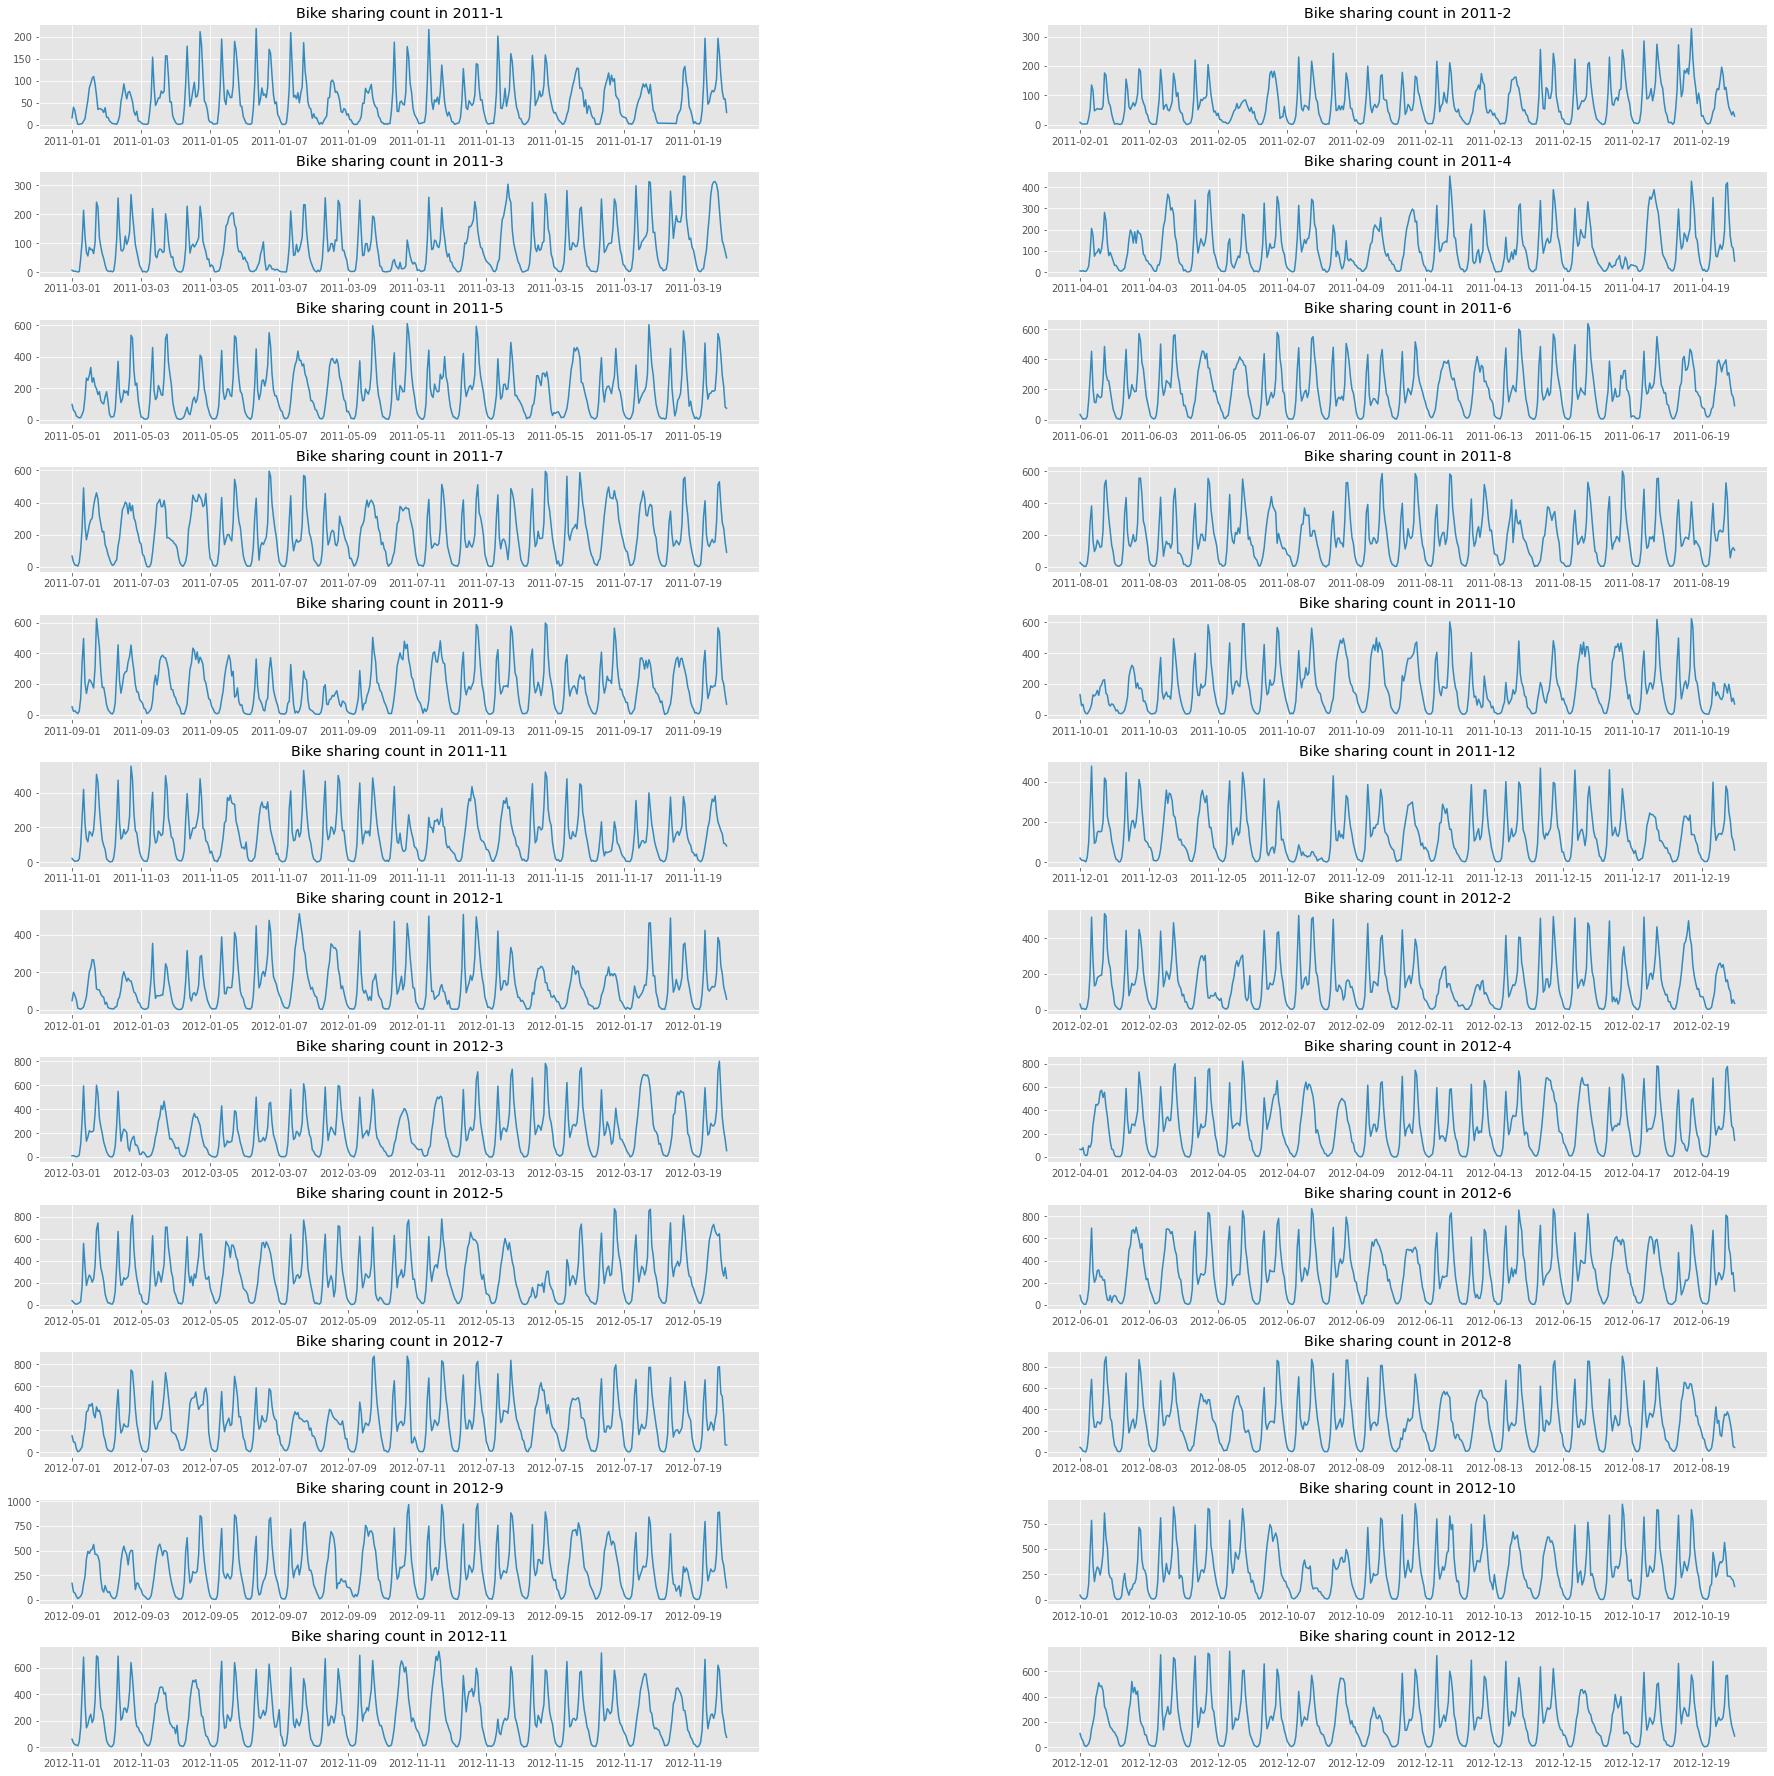

In [183]:
years = [2011, 2012] # all years
months = list(range(1, 13)) # months from 1 to 12

calendar = list(product(years, months))
no_hours = []
plt.figure(figsize = (30,30));
for e, c in enumerate(calendar, 1):
    no_hours.append(select_train(c[0], c[1]).shape[0])
    plt.subplot(12,2, e)
    plt.plot(select_train(c[0], c[1])['count'], color = cycle_colors[1])
    plt.title(f'Bike sharing count in {c[0]}-{c[1]}');
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

In [184]:
# Train dataset ends on the 20th of every month, but each month in train dataset 
# has different number of hours. 
# 20 days * 24 hours = 480 hours, but there isn't a single month with full 480 hours.
# The remaining hours are probably a part of kaggle's secret (unseen) dataset 
# to evaluate your final score when making submissions.
print('Number of hours in train dataset in every month:')
print(*no_hours, sep=' | ')

Number of hours in train dataset in every month:
431 | 446 | 446 | 455 | 456 | 456 | 456 | 456 | 453 | 455 | 456 | 456 | 453 | 455 | 455 | 454 | 456 | 456 | 456 | 456 | 456 | 456 | 455 | 456


### ***4. First prototype model only for one month (January 2011)*** ###

---

Plot train dataset

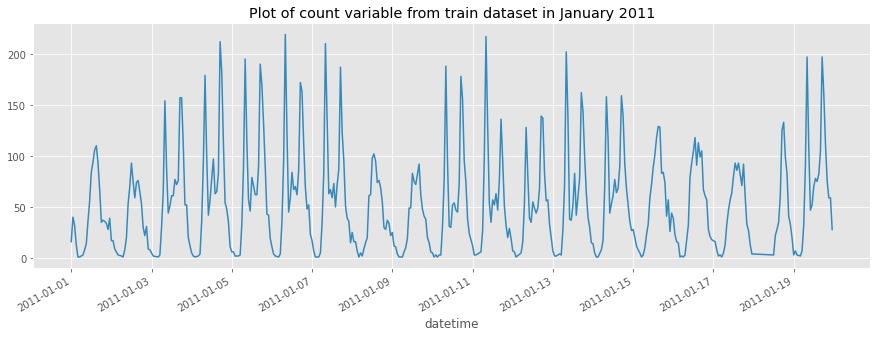

In [185]:
df_month = select_train(2011,1) # January 2011 train data
df_month_test = select_test(2011,1) # January 2011 test dataset 

df_month['count'].plot(figsize = (15,5), color = cycle_colors[1])
plt.title('Plot of count variable from train dataset in January 2011');

Split data into X and y

In [186]:
cols_to_drop = ['count', 'casual', 'registered'] # unneeded columns

In [187]:
X = df_month.drop(cols_to_drop, axis = 1)
y = np.array(df_month['count']).reshape(-1,1)

X.shape, y.shape

((431, 8), (431, 1))

Scale X and y

In [188]:
# Large values can slow down the learning and convergence of LSTM networks
# so a scaler is needed.
scaler = MinMaxScaler(feature_range=(0, 1))
X_trans = scaler.fit_transform(X)
y_trans = scaler.fit_transform(y)

Build trainX and trainY for LSTM

In [189]:
n_future = 1 # predict 1 step into the future...
n_past = 12 # ...based on 24 past steps

# contruct 
trainX = []; trainY = []
for i in range(n_past, len(X_trans) - n_future + 1):
    trainX.append(X_trans[i - n_past:i, 0:X_trans.shape[1]])
    trainY.append(y_trans[i + n_future-1:i + n_future,0])
trainX, trainY = np.array(trainX), np.array(trainY)

In [190]:
trainX.shape, trainY.shape

((419, 12, 8), (419, 1))

Let's understand whats inside trainX by dropping the scaler

---

In [191]:
temp_trainX = []; temp_trainY = []
for i in range(n_past, len(X) - n_future + 1):
    temp_trainX.append(np.array(X)[i - n_past:i, 0:np.array(X).shape[1]])
    temp_trainY.append(y[i + n_future-1:i + n_future,0])
temp_trainX, temp_trainY = np.array(temp_trainX), np.array(temp_trainY)

In [192]:
# The first element of temp_trainX consists of 24 previous elements each containing 10 variables
# (all variabels except 'count')
temp_trainX[0]

array([[ 1.    ,  0.    ,  0.    ,  1.    ,  9.84  , 14.395 , 81.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    ,  9.02  , 13.635 , 80.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    ,  9.02  , 13.635 , 80.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    ,  9.84  , 14.395 , 75.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    ,  9.84  , 14.395 , 75.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  2.    ,  9.84  , 12.88  , 75.    ,
         6.0032],
       [ 1.    ,  0.    ,  0.    ,  1.    ,  9.02  , 13.635 , 80.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    ,  8.2   , 12.88  , 86.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    ,  9.84  , 14.395 , 75.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    , 13.12  , 17.425 , 76.    ,
         0.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    , 15.58  , 19.695 , 76.    ,
        16.9979],
       [ 1.    ,  0. 

In [193]:
# The first element of the first element of temp_trainX is the first row of train dataset (excluding 'count')
temp_trainX[0][0]

array([ 1.   ,  0.   ,  0.   ,  1.   ,  9.84 , 14.395, 81.   ,  0.   ])

In [194]:
# The second element of the first element of temp_trainX is the second row of the train dataset (excluding 'count')
temp_trainX[0][1]

array([ 1.   ,  0.   ,  0.   ,  1.   ,  9.02 , 13.635, 80.   ,  0.   ])

In [195]:
# Let's compare it with first rows of train dataset
df_month.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [196]:
# The second element of the first element of temp_trainX is the second row of data
temp_trainX[1][0]

array([ 1.   ,  0.   ,  0.   ,  1.   ,  9.02 , 13.635, 80.   ,  0.   ])

In [197]:
# The second element of the secont element of temp_trainX is the third row of data
temp_trainX[1][1]

array([ 1.   ,  0.   ,  0.   ,  1.   ,  9.02 , 13.635, 80.   ,  0.   ])

In [198]:
del temp_trainX
del temp_trainY

---

In [199]:
# Dataset (for January 2011) has 407 hours
SPLIT = 300 # number of hours to be considered as train, the rest goes to valid

In [200]:
# Split trainX into train_X and valid_X
# and
# Split trainY into train_y and valid_y
train_X = trainX[:SPLIT, :]
valid_X = trainX[SPLIT:, :]

train_y = trainY[:SPLIT, :]
valid_y = trainY[SPLIT:, :]

In [201]:
# Sample model constructed as a blueprint
model = Sequential()
model.add(Bidirectional(LSTM(50,input_shape=(trainX.shape[1],trainX.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer="adam",loss="mse") # mse choosed as default error
history = model.fit(trainX, trainY, epochs=150, batch_size=24, validation_data=(valid_X, valid_y), shuffle=False, verbose = 2)

Epoch 1/150
18/18 - 6s - loss: 0.0780 - val_loss: 0.0514 - 6s/epoch - 360ms/step
Epoch 2/150
18/18 - 0s - loss: 0.0643 - val_loss: 0.0449 - 363ms/epoch - 20ms/step
Epoch 3/150
18/18 - 1s - loss: 0.0568 - val_loss: 0.0411 - 531ms/epoch - 29ms/step
Epoch 4/150
18/18 - 1s - loss: 0.0495 - val_loss: 0.0359 - 626ms/epoch - 35ms/step
Epoch 5/150
18/18 - 0s - loss: 0.0463 - val_loss: 0.0335 - 496ms/epoch - 28ms/step
Epoch 6/150
18/18 - 0s - loss: 0.0490 - val_loss: 0.0317 - 448ms/epoch - 25ms/step
Epoch 7/150
18/18 - 0s - loss: 0.0461 - val_loss: 0.0285 - 445ms/epoch - 25ms/step
Epoch 8/150
18/18 - 0s - loss: 0.0430 - val_loss: 0.0266 - 458ms/epoch - 25ms/step
Epoch 9/150
18/18 - 0s - loss: 0.0444 - val_loss: 0.0258 - 499ms/epoch - 28ms/step
Epoch 10/150
18/18 - 1s - loss: 0.0389 - val_loss: 0.0236 - 502ms/epoch - 28ms/step
Epoch 11/150
18/18 - 0s - loss: 0.0387 - val_loss: 0.0231 - 462ms/epoch - 26ms/step
Epoch 12/150
18/18 - 1s - loss: 0.0379 - val_loss: 0.0223 - 523ms/epoch - 29ms/step
Epo

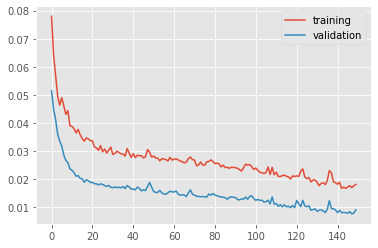

In [202]:
# Plot learning curves
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend();

In [203]:
yhat = model.predict(valid_X) # prediction needed to evaluate the model 
yhat[yhat<0] = 0 # no negative bike sharing counts

In [204]:
yhat # yhat is scaled with the scaler, the is no need to rescale it for error calculations

array([[0.32153383],
       [0.30815566],
       [0.31679362],
       [0.39491487],
       [0.5070961 ],
       [0.61180013],
       [0.6436443 ],
       [0.5380822 ],
       [0.42767167],
       [0.24775863],
       [0.11823369],
       [0.01396294],
       [0.07589656],
       [0.15725794],
       [0.1652228 ],
       [0.12366033],
       [0.05647625],
       [0.01616053],
       [0.04751873],
       [0.05572664],
       [0.12121777],
       [0.18210903],
       [0.26277825],
       [0.3547241 ],
       [0.394837  ],
       [0.40726888],
       [0.48115575],
       [0.55374837],
       [0.5382074 ],
       [0.49911046],
       [0.4313377 ],
       [0.36957422],
       [0.28462574],
       [0.2403642 ],
       [0.20072573],
       [0.1597012 ],
       [0.16724795],
       [0.1201598 ],
       [0.08947712],
       [0.07121219],
       [0.04552818],
       [0.0574696 ],
       [0.08607478],
       [0.14598528],
       [0.21096468],
       [0.31457254],
       [0.39196405],
       [0.406

In [205]:
# Two randomly selected errors choosen for calculations
rmse_error = sqrt(mean_squared_error(valid_y, yhat))
rmsle_error = sqrt(mean_squared_log_error(valid_y, yhat))
print(f'Test RMSE: {rmse_error:.4f}')
print(f'Test RMSLE: {rmsle_error:.4f}')

Test RMSE: 0.0946
Test RMSLE: 0.0724


Get dates for forecasting

In [206]:
n_predict = select_test(2011,1).shape[0] 
forecast_period_dates = df_month_test[:n_predict].index # dates to forecast (needed later for forecast plot)
forecast_period_dates

DatetimeIndex(['2011-01-20 00:00:00', '2011-01-20 01:00:00',
               '2011-01-20 02:00:00', '2011-01-20 03:00:00',
               '2011-01-20 04:00:00', '2011-01-20 05:00:00',
               '2011-01-20 06:00:00', '2011-01-20 07:00:00',
               '2011-01-20 08:00:00', '2011-01-20 09:00:00',
               ...
               '2011-01-31 14:00:00', '2011-01-31 15:00:00',
               '2011-01-31 16:00:00', '2011-01-31 17:00:00',
               '2011-01-31 18:00:00', '2011-01-31 19:00:00',
               '2011-01-31 20:00:00', '2011-01-31 21:00:00',
               '2011-01-31 22:00:00', '2011-01-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=257, freq=None)

In [207]:
# how many hours to forecast (from the 20th to the end of month)
n_predict

257

Perform forecast

In [208]:
forecast = model.predict(trainX[-n_predict:])

In [209]:
forecast_copies = np.repeat(forecast, X.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

# np.repeat(forecast, X.shape[1], axis=-1)[:,0]
# transforms output from
# array([[0.3767641 ],
#       [0.41019553],
#       [0.41848484],
#       [0.3720415 ],
#       [0.3122611 ], ...
# to
# array([0.3767641 , 0.41019553, 0.41848484, 0.3720415 , 0.3122611 ,...])

y_pred_future = y_pred_future.astype(int) # convert to integers
y_pred_future[y_pred_future<0] = 0 # no negative bike sharing counts

Put predicted values into a dataframe

In [210]:
df_forecast = pd.DataFrame({'datetime': np.array(forecast_period_dates), 'count': y_pred_future})
df_forecast.index = pd.to_datetime(df_forecast['datetime'])
del df_forecast['datetime']
df_forecast

,count
datetime,
2011-01-20 00:00:00,93
2011-01-20 01:00:00,96
2011-01-20 02:00:00,83
2011-01-20 03:00:00,85
2011-01-20 04:00:00,80
...,...
2011-01-31 19:00:00,109
2011-01-31 20:00:00,71
2011-01-31 21:00:00,49


Plot traning and predicted data

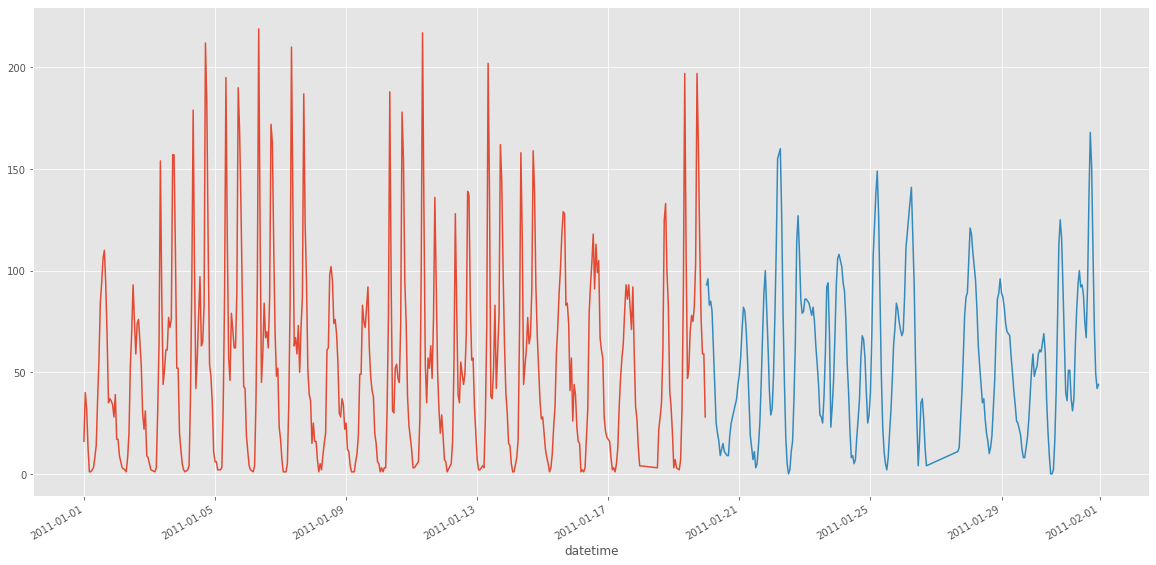

In [211]:
plt.figure(figsize=(20,10))
df_month['count'].plot()
df_forecast['count'].plot();

### ***5. Adapt presented steps for full 2 years*** ###

---

In [212]:
# linear, tanh, sigmoid, relu
activacation_function = 'relu'

In [213]:
bidi_dropout_model = Sequential([
            Bidirectional(LSTM(50, input_shape = (trainX.shape[1], trainX.shape[2]))),
            Dropout(0.2),
            Dense(units=1, activation= activacation_function)
        ])

In [214]:
bidi_model = Sequential([
            Bidirectional(LSTM(50, input_shape = (trainX.shape[1], trainX.shape[2]))),
            Dense(units=1, activation = activacation_function)
        ])

In [215]:
dropout_model = Sequential([
            LSTM(50, input_shape = (trainX.shape[1], trainX.shape[2])),
            Dropout(0.2),
            Dense(units=1, activation = activacation_function)
        ])

In [216]:
models = [
    ('Bidirectional Dropout', bidi_dropout_model),
    ('Bidirectional', bidi_model),
    ('Dropout', dropout_model)
]

In [219]:
def run_experiments(train_dataset, models, exp_name = 'lstm', use_neptune = False, n_past = 12, SPLIT = 300, print_learning_errors = 0, save_csv_for_kaggle = True):

    # empty dataframe for locally keeping track of results
    models_df = pd.DataFrame()

    # data scaler
    # scaler = RobustScaler()
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    cols_to_drop = ['count', 'casual', 'registered'] # unneeded columns
    metrics = ['mse', 'mae', 'msle', rmse, rmsle, r2] # used metrics

    # string names of used metrics
    metrics_str = [metric if type(metric) == str else metric.__name__ for metric in metrics]

    # split dataframe into train and valid
    def train_valid_X_y_split(trainX, trainY, SPLIT = SPLIT):
        train_X = trainX[:SPLIT, :]
        valid_X = trainX[SPLIT:, :]
        train_y = trainY[:SPLIT, :]
        valid_y = trainY[SPLIT:, :]
        return train_X, valid_X, train_y, valid_y

    # rescale data back to origal format (needed for prediction)
    def rescale(forecast):
        forecast_copies = np.repeat(forecast, df_train.shape[1], axis = -1)
        y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

        y_pred_future = y_pred_future.astype(int) # convert to integers
        y_pred_future[y_pred_future<0] = 0 # no negative bike sharing counts

        return y_pred_future

    # plot training history
    def plot_history(history, error_name, year, month, model_name, use_neptune = False):
            fig = plt.figure()
            plt.plot(history.history[f'{error_name}'], label = 'training')
            plt.plot(history.history[f'val_{error_name}'], label = 'validation')
            plt.title(f'{error_name.upper()} for {year}-{month}')
            plt.suptitle(f'{model_name}')
            plt.xlabel('epoch')
            plt.ylabel('error')
            plt.legend(loc='best')
            if use_neptune:
                neptune.log_image(f'{error_name}_plot', fig)
            plt.show();

    # plot current bike counts in a given month with forecasts
    def plot_current_and_forect(year, month, y_pred_future, use_neptune):
        df_month_test = select_test(year, month)
        n_predict = df_month_test.shape[0]
        forecast_period_dates = df_month_test[:n_predict].index

        df_forecast = pd.DataFrame({'datetime': np.array(forecast_period_dates), 'count': y_pred_future})
        df_forecast.index = pd.to_datetime(df_forecast['datetime'])
        del df_forecast['datetime']


        fig = plt.figure(figsize=(20,10))
        plt.title(f'Forecast for {year}-{month}')
        df_month['count'].plot()
        df_forecast['count'].plot();
        if use_neptune:
            neptune.log_image('forecast', fig)
        return df_forecast

    # initialize neptune if needed
    if use_neptune:
        run = init_neptune()

    # get max number of months in dataset
    max_month = max(pd.Series(train_dataset.index).dt.month)

    # list of all months in dataset
    months = list(range(1, max_month + 1))

    # list of all years in dataset
    years = list(set(pd.Series(train_dataset.index).dt.year))

    # list of possible years and months put together
    month_year_list = list(product(years, months))


    e = 1 # experiment number
    for (m, model_object) in enumerate(models, 1):

        model_name = model_object[0] # model name
        model = model_object[1] # model instance
        df_kaggle = pd.DataFrame() # make empty dataframe for Kaggle Late Submission
        print('='*30)
        print(f'{model_name}')
        print('='*30)

        for year_month in month_year_list:

            if use_neptune:
                neptune.create_experiment(f'{exp_name}-{e}')
            e +=1

            year = year_month[0] # current year
            month = year_month[1] # current month

            print(f'Building LSTM for {year}-{month}...')

            df_month = select_train(year, month) # train dataset of current month

            # get X and y from train dataset
            X = df_month.drop(cols_to_drop, axis = 1)
            y = np.array(df_month['count']).reshape(-1,1)

            # scale data
            X_trans = scaler.fit_transform(X)
            y_trans = scaler.fit_transform(y)

            # construct arrays of past values
            trainX = []; trainY = []
            for i in range(n_past, len(X_trans) - 2):
                trainX.append(X_trans[i-n_past:i, 0:X_trans.shape[1]])
                trainY.append(y_trans[i : i +1, 0])
            trainX, trainY = np.array(trainX), np.array(trainY)

            # split dataset to train and valid
            train_X, valid_X, train_y, valid_y = train_valid_X_y_split(trainX, trainY)

            # compile and fit model
            model.compile(optimizer="adam", loss = "mse", metrics = metrics)
            history = model.fit(trainX, trainY, epochs=150, batch_size=24, validation_data=(valid_X, valid_y), shuffle=False, verbose = print_learning_errors)

            # dictionary with basic model info (strings)
            info_dict = {
                'method': 'LSTM',
                'year_month': f'{year}-{month}',
                'model_custom_name': model_name,
                'n_past': str(n_past),
                'activation': str(activacation_function)
            }

            # dictionary with all metrics (floats)
            metrics_dict = dict()
            for key in history.history.keys():
                metrics_dict[f'{key}_curr'] = history.history[key][-1]
                metrics_dict[f'{key}_min'] = min(history.history[key])
            
            del metrics_dict['r2_min'] # no need for minimal r2 error
            del metrics_dict['val_r2_min'] 

            metrics_dict['r2_max'] = max(history.history['r2']) # add maximal r2 error
            metrics_dict['val_r2_max'] = max(history.history['val_r2'])
            
            # log values depending on their type (str or float)
            if use_neptune:
                for key, value in info_dict.items():
                    neptune.log_text(key, value)
                
                for key, value in metrics_dict.items():
                    neptune.log_metric(key, value)            

            # combine dictionaries
            param_dict = {**info_dict, **metrics_dict}

            # plot learning curves of every metric
            for metric in metrics_str:
                plot_history(history, error_name = metric, year = year, month = month, model_name= model_name, use_neptune = use_neptune)

            # forecasting
            n_predict = select_test(year, month).shape[0]
            forecast = model.predict(trainX[-n_predict:])
            y_pred_future = rescale(forecast)

            # plot forecast and make kaggle late submission dataset
            df_forecast = plot_current_and_forect(year, month, y_pred_future, use_neptune = use_neptune)
            df_kaggle = pd.concat([df_kaggle, df_forecast])

            # add row into summary dataframe for local results
            models_df = models_df.append(pd.DataFrame(param_dict, index = [0]))
            
        # save predicitons for future days as csv for kaggle late submission
        if save_csv_for_kaggle:
            df_kaggle.to_csv(f'submission_{model_name}_n_past{n_past}_{activacation_function}.csv') # save for Kaggle Late Submission
        
        # if use_neptune:
            # neptune.stop()

    models_df.reset_index(drop = True, inplace = True)

    # end neptune instance
    if use_neptune:
        neptune.stop()

    return models_df

In [ ]:
models_df = run_experiments(df_train, models, use_neptune = False, n_past = 12, print_learning_errors = 0, save_csv_for_kaggle = True)

In [ ]:
models_df

,method,year_month,model_custom_name,scaled_data,loss_curr,loss_min,mse_curr,mse_min,mae_curr,mae_min,...,val_mae_min,val_msle_curr,val_msle_min,val_rmse_curr,val_rmse_min,val_rmsle_curr,val_rmsle_min,val_r2_curr,r2_max,val_r2_max
0,LSTM,2011-1,Bidirectional Dropout,True,0.042103,0.039175,0.042103,0.039175,0.154712,0.149474,...,0.110312,0.006784,0.005854,0.151926,0.150278,0.163873,0.139439,0.949926,0.919687,0.951084
1,LSTM,2011-2,Bidirectional Dropout,True,0.035881,0.029101,0.035881,0.029101,0.144964,0.126236,...,0.100868,0.005841,0.004883,0.151428,0.133812,0.130192,0.104740,0.960219,0.939333,0.968516
2,LSTM,2011-3,Bidirectional Dropout,True,0.021572,0.018070,0.021572,0.018070,0.109682,0.102448,...,0.062195,0.001933,0.001933,0.077472,0.077472,0.080157,0.079204,0.989658,0.958969,0.989658
3,LSTM,2011-4,Bidirectional Dropout,True,0.016024,0.015362,0.016024,0.015362,0.096474,0.093529,...,0.052174,0.001375,0.001002,0.080495,0.068896,0.074383,0.071523,0.964235,0.965774,0.965556
4,LSTM,2011-5,Bidirectional Dropout,True,0.013194,0.012617,0.013194,0.012617,0.085480,0.085207,...,0.041414,0.001058,0.000755,0.057798,0.055045,0.070293,0.070161,0.990706,0.969621,0.991988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,LSTM,2012-8,Dropout,True,0.009284,0.007645,0.009284,0.007645,0.074995,0.066889,...,0.033271,0.001045,0.000513,0.052652,0.041668,0.067999,0.063033,0.989586,0.978453,0.993672
68,LSTM,2012-9,Dropout,True,0.009105,0.008115,0.009105,0.008115,0.072850,0.068722,...,0.036302,0.000641,0.000641,0.050296,0.047897,0.062713,0.056475,0.992107,0.978125,0.992416
69,LSTM,2012-10,Dropout,True,0.015738,0.011019,0.015738,0.011019,0.091731,0.080266,...,0.040236,0.001186,0.000824,0.061967,0.052095,0.081701,0.069083,0.990884,0.974682,0.994426
70,LSTM,2012-11,Dropout,True,0.008758,0.007732,0.008758,0.007732,0.073980,0.069195,...,0.032068,0.000635,0.000485,0.047147,0.044747,0.060355,0.058560,0.993932,0.980352,0.994665


In [ ]:
models_df.to_csv('lstm_models_summary.csv')